# WICCA: Wavelet-based Image Compression & Classification Analysis

WICCA is a research framework exploring the impact of wavelet compression on image classification performance.
The current goal is to assess whether reducing image size via Haar wavelet transformation retains enough information for accurate classification.

### Objectives
- Apply Haar wavelet compression to large images (>2K resolution).
- Evaluate classification performance on both original and compressed images.
- Compare results across multiple pre-trained models.


## Imports

In [1]:
import os

import cv2
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.applications as apps
from pathlib import Path

import utility.visualization as viz
import utility.result_manager as rmgr
from utility.data_loader import load_image, load_models
from utility.wavelet_coder import HaarCoder
from utility.classifying_tools import ClassifierProcessor
from settings.constants import SIM_CLASSES, SIM_CLASSES_PERC, SIM_BEST_CLASS, RESULTS_FOLDER

%matplotlib inline
pd.set_option('display.float_format', '{:.5f}'.format)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0=DEBUG, 1=INFO, 2=WARNING, 3=ERROR

## Models
Let's load our [models](https://keras.io/api/applications/).

To load image classification models, provide a dictionary that maps model names to their classes
- Keys: Descriptive model names (strings)
- Values: Either a model class reference OR a tuple of (model class, configuration dict)
- Use tuples for models requiring non-standard input shapes (e.g., 299×299 instead of 224×224)


In [2]:
models_dict = {
    # Mobile Networks (standard 224×224)
    'MobileNetV2': apps.mobilenet_v2.MobileNetV2,

    # VGG family (standard 224×224)
    'VGG16': apps.vgg16.VGG16,
    'VGG19': apps.vgg19.VGG19,

    # ResNet family (standard 224×224)
    'ResNet50': apps.resnet50.ResNet50,
    'ResNet101': apps.resnet.ResNet101,
    # 'ResNet152': apps.resnet.ResNet152,

    # DenseNet family (standard 224×224)
    # 'DenseNet121': apps.densenet.DenseNet121,
    'DenseNet169': apps.densenet.DenseNet169,
    'DenseNet201': apps.densenet.DenseNet201,

    # NasNet family (custom shapes)
    'NASNetMobile': apps.nasnet.NASNetMobile,  # Uses 224×224
    'NASNetLarge': (apps.nasnet.NASNetLarge, {'shape': (331, 331)}),

    # Inception family (custom shapes)
    'InceptionV3': (apps.inception_v3.InceptionV3, {'shape': (299, 299)}),
    'InceptionResNetV2': (apps.inception_resnet_v2.InceptionResNetV2, {'shape': (299, 299)}),

    # Xception (custom shape)
    'Xception': (apps.xception.Xception, {'shape': (299, 299)}),
}

standard_shape_models_dict = {
    'MobileNetV2': apps.mobilenet_v2.MobileNetV2,
    'VGG16': apps.vgg16.VGG16,
    # 'VGG19': apps.vgg19.VGG19,
    'ResNet50': apps.resnet50.ResNet50,
    # 'ResNet101': apps.resnet.ResNet101,
    # 'DenseNet169': apps.densenet.DenseNet169,
    # 'DenseNet201': apps.densenet.DenseNet201,
    'NASNetMobile': apps.nasnet.NASNetMobile,
    # 'ResNet152': apps.resnet.ResNet152,
    'EfficientNetB0': apps.efficientnet.EfficientNetB0,
    # 'DenseNet121': apps.densenet.DenseNet121,
    # 'EfficientNetB1': (apps.efficientnet.EfficientNetB1, {'shape': (240, 240)})
}

single_model = {
    "MobileNetV2": apps.mobilenet_v2.MobileNetV2
}

# classifiers = load_models(models_dict)
classifiers = load_models(standard_shape_models_dict)

Loading classifiers:   0%|          | 0/5 [00:00]

### Data load

Sample image

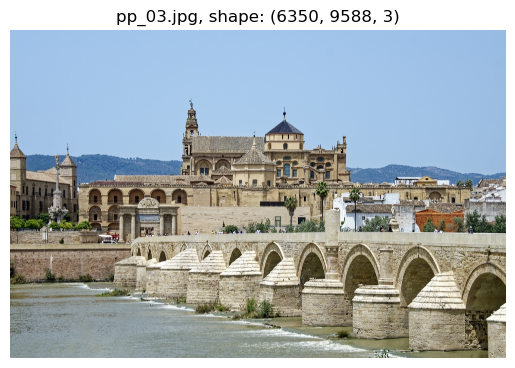

In [3]:
path = Path('data/orig')
list_dir = [f.name for f in path.iterdir()]

idx = list_dir[2]
sample = load_image(f'{path}/{idx}')

plt.imshow(sample)
plt.axis('off')
plt.title(f'{idx}, shape: {sample.shape}')
plt.show()

## Analysis

To start out analysis we need to define a processor.
The `ClassifierProcessor` is designed to handle large-image datasets efficiently. It can process images in parallel, save results automatically, and provide visualization tools to compare original images with their classified icons.
The class takes care of all preprocessing required by each model, manages the classification workflow, and organizes results in a structured format for easy analysis. After processing, you'll find detailed classification results in your specified results folder, ready for further analysis or visualization.


There is some validation for depth input, but it is highly recommended to pass only in specified below formats.

**Please be aware, that process might take quite a while for large datasets.**

ClassifierProcessor supports a variety of depth inputs

In [4]:
depth = 5
depth_tuple = (3, 4)
depth_range = [5,6]
depth_list = [2, 6]
depth_tuple_list = [(3, 4), (4, 5), (5, 6)] # would fail

By default, it tries to save results into the "results" folder in the project core folder. You can change this folder by defining a new path using pathlib or just providing it as str, and passing it as an argument

In [5]:
data_folder = 'data/orig'

res_folder_path = Path('C:/101AwesomeProject/results')
res_folder_str = 'C:/101AwesomeProject/results'

res_default = RESULTS_FOLDER

## Single depth

In [6]:
processor = ClassifierProcessor(
    data_folder=data_folder,  # Directory containing images to process
    wavelet_coder=HaarCoder(),  # Defines our wavelet
    transform_depth=depth_range,  # Defines the depth of transforming
    top_classes=5,  # Defines top classes for comparison
    interpolation=cv2.INTER_AREA,  # Interpolation method. See https://docs.opencv.org/3.4/da/d54/group__imgproc__transform.html
    result_manager=rmgr,  # Result manager module
    results_folder=res_default,  # Where to save results
    log_info=True,  # Output related info. Enabled by default
    parallel=None, # What means infinity
    batch_size=30 # Size of image batch for classifier
)

Gathering info:   0%|          |[00:00]


#### Image Processing Configuration
Note: For image stats was taken a sample of 50 random images.
You may change the sample size [MAX_INFO_SAMPLE_SIZE] in the settings.constants module.
- **Data folder:** data\orig
- **Number of images:** 130
- **Mean image dimensions:** 8416x6126 px
- **Mean image resolution:** 51.4 MP (51420121 pixels)
- **Transform depth:** (5, 6)
- **Interpolation:** cv2.INTER_AREA
- **Top classes:** 5
- **Results folder:** C:\MyProjects\WICCA\results
                

General use of this framework to classify a batch of classifiers:

In [7]:
processor.process_classifiers(classifiers, timeout=3600)

Processing depth 5:   0%|          |[00:00]

Processing depth 6:   0%|          |[00:00]

Total processing time: 10 minutes 44 seconds


Though, you can just pass single a dict with classifier

In [8]:
single_classifier = load_models(single_model)
processor.process_classifiers(single_classifier)

Loading classifiers:   0%|          | 0/1 [00:00]

Processing depth 5:   0%|          |[00:00]

Processing depth 6:   0%|          |[00:00]

Total processing time: 5 minutes 34 seconds


Additionally, you could access single model from already loaded. However, some rules should be followed.
You should use following format

`process_single_classifier("model_name_you_specified", classfiers_dict["model_name_you_specified"], timeout) `

In [9]:
processor.process_single_classifier("MobileNetV2", classifiers["MobileNetV2"], timeout=3600)

Processing depth 5:   0%|          |[00:00]

Processing depth 6:   0%|          |[00:00]

Total processing time: 5 minutes 18 seconds


 ### Results presentation
Let's have a look at our results

MobileNetV2

In [10]:
rmgr.load_summary_results(res_default, 'MobileNetV2', 5)    # We can call results either by loading csv or
# results['MobileNetV2']                          # By directly looking into "results" dataframe in case of multi classifier analysis

Unnamed: 0  similar classes (count)  similar classes (%)  similar best class
0      count                130.00000            130.00000           130.00000
1       mean                  4.04615             80.92308            76.15385
2        std                  0.74565             14.91299            42.77913
3        min                  2.00000             40.00000             0.00000
4        25%                  4.00000             80.00000           100.00000
5        50%                  4.00000             80.00000           100.00000
6        75%                  5.00000            100.00000           100.00000
7        max                  5.00000            100.00000           100.00000

VGG16

In [11]:
rmgr.load_summary_results(res_default, depth = 5, classifier_name='EfficientNetB0')
# results['VGG16']

Unnamed: 0  similar classes (count)  similar classes (%)  similar best class
0      count                130.00000            130.00000           130.00000
1       mean                  4.24615             84.92308            83.84615
2        std                  0.76818             15.36361            36.94506
3        min                  1.00000             20.00000             0.00000
4        25%                  4.00000             80.00000           100.00000
5        50%                  4.00000             80.00000           100.00000
6        75%                  5.00000            100.00000           100.00000
7        max                  5.00000            100.00000           100.00000

#### Compare classifiers by single depth

Let's extract values for some visualization

In [12]:
comparison = rmgr.compare_summaries(res_default, classifiers, 5, 'mean')
names, similar_classes_pct = rmgr.extract_from_comparison(comparison, 'similar classes (%)')
names, similar_best_class = rmgr.extract_from_comparison(comparison, 'similar best class')
# similar_best_class = similar_best_class * 100

### Similar classes

In [13]:
viz.plot_metric_radar(names, similar_classes_pct, 'Top 5 Similarity', min_value=75)

### The best class similarity

In [14]:
viz.plot_metric_radar(names, similar_best_class, "Top 1 Similarity", min_value=75)

In [15]:
viz.plot_compare_metrics(names, similar_classes_pct, similar_best_class)

##  Results comparison for different depths
In this block we compare classifying performance by multiple classifiers

Let's visualize how different depth of transformation affect our images.

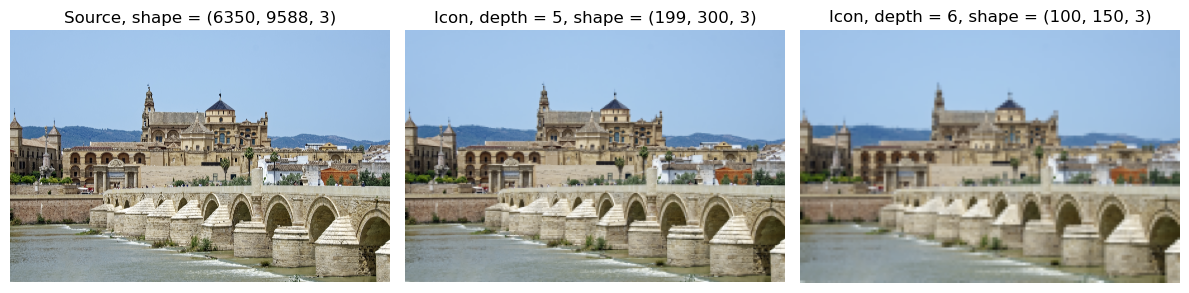

In [16]:
viz.show_image_vs_icon(sample, depth_range, coder=HaarCoder())

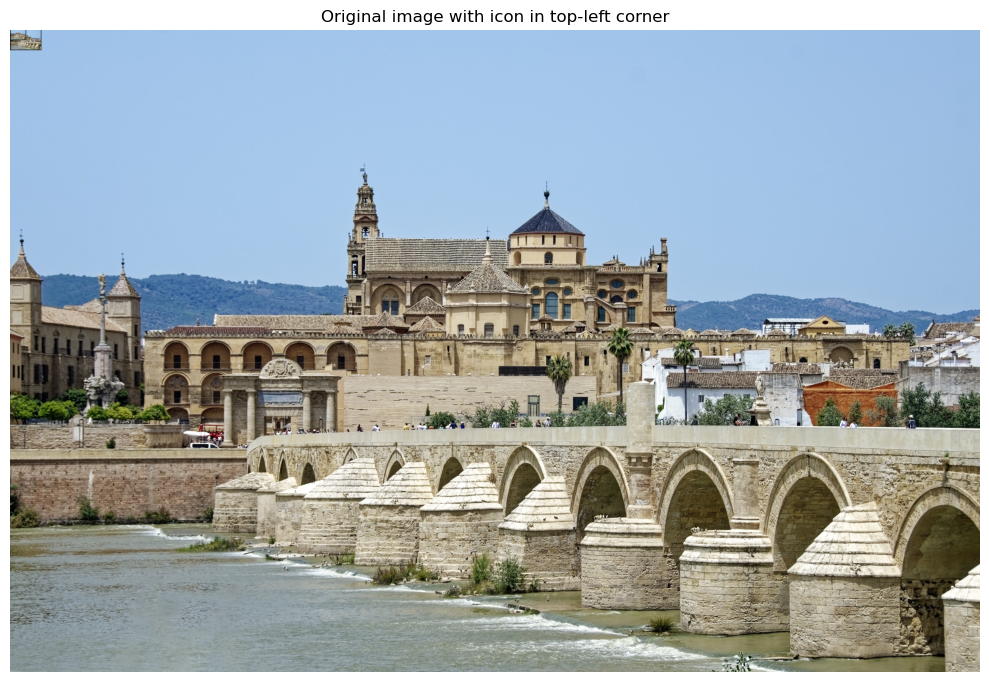

In [17]:
viz.show_icon_on_image(sample, depth_range, coder=HaarCoder(), border_width=5, border_color=(0, 0, 0))

A heatmap for visualization similar classes cases by models

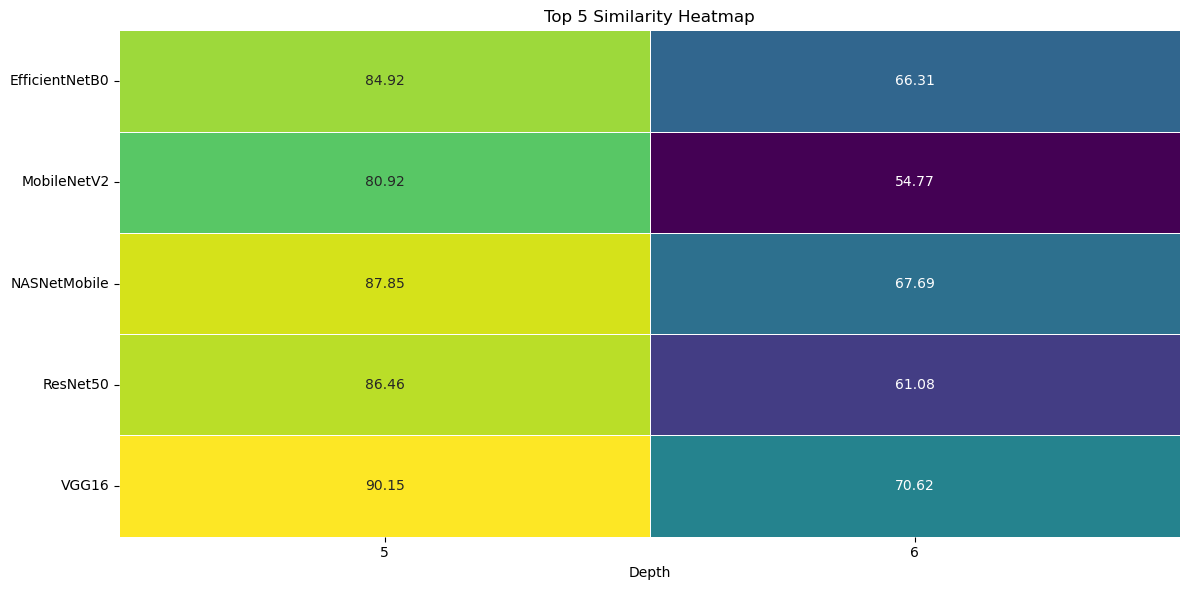

In [18]:
x = rmgr.compare_summaries(res_default, classifiers, depth_range, "mean")
viz.visualize_comparison(x, SIM_CLASSES_PERC, title="Top 5 Similarity Heatmap")

Same for the best class cases

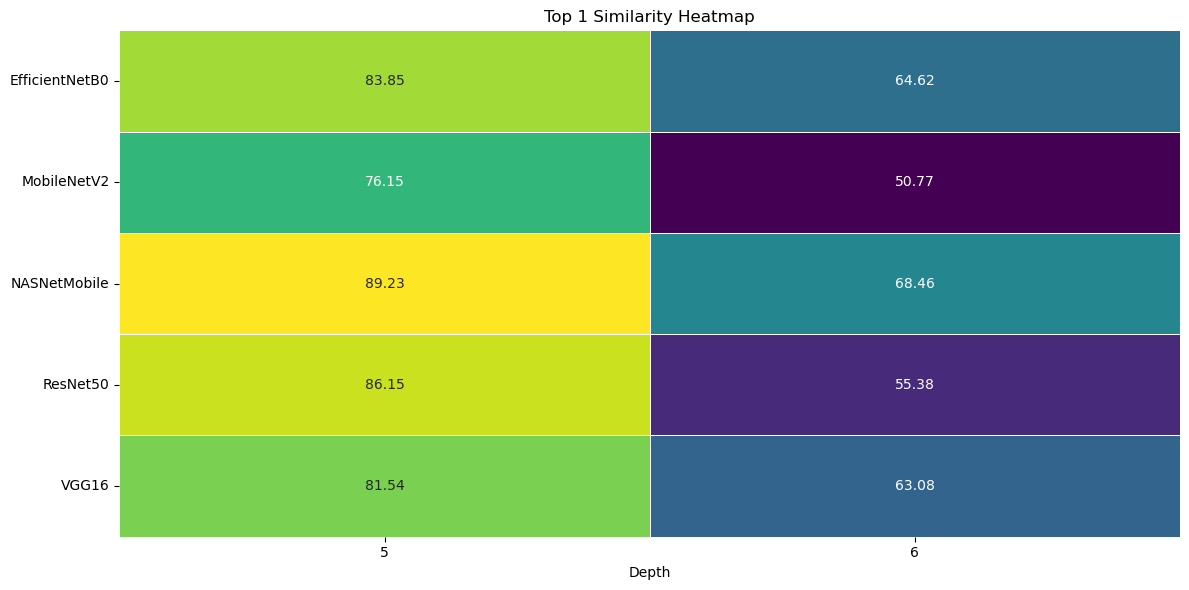

In [19]:
viz.visualize_comparison(x, SIM_BEST_CLASS, title="Top 1 Similarity Heatmap")

# Key insights
from 12.03.2025
need update



### Model Performance at Depth 5
- **VGG Family Performance:** VGG16 and VGG19 demonstrate superior performance in similar class percentage metrics, with VGG19 outperforming VGG16 in maintaining classification consistency.
- **Best Class Similarity:** NASNet family models (particularly NASNetMobile) and ResNet50 excel at preserving the top predicted class despite compression, while VGG models show slightly lower performance in this metric.
- **MobileNetV2 Performance:** As expected, MobileNetV2 shows the weakest performance across all evaluation metrics, likely due to its architecture optimized for mobile deployment rather than robustness.
- **Surprising Finding:** Despite its smaller size, NASNetMobile demonstrates superior performance compared to NASNetLarge, suggesting that model complexity doesn't always correlate with compression resilience
### Compression Impact
- **Classification Consistency:** All models maintain at least 80.5% similarity in predicted classes between original and compressed images at depth 5.
- **Top Class Preservation:** For the best (top) class similarity, all models maintain at least 76% consistency between original and compressed versions.
- **Effect of Haar Compression:** The transformation significantly reduces image size while retaining recognizable features essential for classification.
### Depth Analysis (3-6)
- **Progressive Performance Decline:** Two distinct performance drops are observed as compression depth increases:
    - At depth 3: All models show metrics near 100% (minimal impact on classification)
    - At depth 5: Performance declines to 80-90% range
    - From depth 6: Significant degradation with metrics falling to 55-71%
### Conclusions
- Results suggest depth 5 represents an optimal balance between compression and classification performance for most models.
- For applications requiring large image processing, using compressed representations offers substantial storage/computational savings with acceptable classification performance.

# Next Steps
### API Implementation
- Develop a Flask-based API to expose the classification functionality as a service.
- Key API Endpoints:
  - `POST /classify`: Accept image uploads (original or compressed) and return classification results for all supported models.
  - `GET /models`: Retrieve a list of available classifiers and their supported functionalities (e.g., input size, preprocessing requirements).
  - `GET /compare`: Provide a summary comparison of model performance metrics for given depths (e.g., average similarity percentages).
- Include robust error handling and validation for uploaded images (e.g., format, size).
- Add support for batch image uploads to ensure scalability for large datasets.
- Integrate the Haar compression process, enabling clients to specify compression depth via API input.

### Future Research
- Extend analysis to other wavelet types (Daubechies, Coiflet) for better approximation properties and potentially improved classifier resilience after compression.
- Explore the impact of multi-wavelet techniques on performance consistency across various depths.
- Investigate adaptive compression techniques that adjust based on image content
- Explore the relationship between image content type and optimal compression parameters


### Additional Testing
- Evaluate classification performance using diverse datasets, including medical imaging, satellite photography, and cultural heritage archives, to validate findings across different image categories and characteristics.
- Benchmark computational efficiency gains from using compressed images
- Conduct ablation studies to identify which image features are most critical for classification preservation
